### 8.1 텐서플로 허브
텐서플로에서 제공하는 텐서플로 허브는 재사용 가능한 모델을 쉽게 이용할 수 있는 라이브러리이다. 텐서플로 허브 홈페이지에서는 이미지, 텍스트, 비디오 등의 분야에서 사전 훈련된 모델들을 검색해볼 수 있다.

In [1]:
!pip install tensorflow==2.0.0

     |████████████████████████████████| 86.3MB 36kB/s 
     |████████████████████████████████| 450kB 32.8MB/s 
     |████████████████████████████████| 3.8MB 26.1MB/s 
  Found existing installation: tensorflow-estimator 1.15.1
    Uninstalling tensorflow-estimator-1.15.1:
      Successfully uninstalled tensorflow-estimator-1.15.1
  Found existing installation: tensorboard 1.15.0
    Uninstalling tensorboard-1.15.0:
      Successfully uninstalled tensorboard-1.15.0
  Found existing installation: tensorflow 1.15.0
    Uninstalling tensorflow-1.15.0:
      Successfully uninstalled tensorflow-1.15.0


In [2]:
# 텐서플로 허브에서 사전 훈련된 MobileNet 모델 불러오기
import tensorflow_hub as hub
import tensorflow as tf

mobile_net_url = "https://tfhub.dev/google/tf2-preview/mobilenet_v2/classification/2"
model = tf.keras.Sequential([
                             hub.KerasLayer(handle=mobile_net_url, input_shape=(224,224,3), trainable=False)
])

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer (KerasLayer)     (None, 1001)              3540265   
Total params: 3,540,265
Trainable params: 0
Non-trainable params: 3,540,265
_________________________________________________________________


In [3]:
# ImageNetV2-TopImages 불러오기
# 함수의 인수 중 extract=True 로 지정했기 때문에 tar.gz 형식의 압축 파일이 자동으로 해제되어 구글 코랩 가상 머신에 저장
import os
import pathlib
content_data_url='/content/sample_data'
data_root_orig = tf.keras.utils.get_file('imagenetV2', 'https://s3-us-west-2.amazonaws.com/imagenetv2public/imagenetv2-topimages.tar.gz',
                                        cache_dir=content_data_url, extract=True)
data_root = pathlib.Path(content_data_url + '/datasets/imagenetv2-topimages')
print(data_root)

606355456/606351360 [==============================] - 15s 0us/step
/content/sample_data/datasets/imagenetv2-topimages


In [4]:
# 디렉토리 출력
# 데이터를 잘 불러왔는지 확인하기 위해 하위 디렉토리를 순회하며 디렉토리의 경로를 출력 (하위 디렉토리: 0 ~ 999까지 총 1000개)
for idx, item in enumerate(data_root.iterdir()):
  print(item)
  if idx == 9:
    break

/content/sample_data/datasets/imagenetv2-topimages/133
/content/sample_data/datasets/imagenetv2-topimages/520
/content/sample_data/datasets/imagenetv2-topimages/805
/content/sample_data/datasets/imagenetv2-topimages/221
/content/sample_data/datasets/imagenetv2-topimages/502
/content/sample_data/datasets/imagenetv2-topimages/845
/content/sample_data/datasets/imagenetv2-topimages/223
/content/sample_data/datasets/imagenetv2-topimages/324
/content/sample_data/datasets/imagenetv2-topimages/888
/content/sample_data/datasets/imagenetv2-topimages/745


In [5]:
# ImageNet 라벨 텍스트 불러오기
label_file = tf.keras.utils.get_file('label', 'https://storage.googleapis.com/download.tensorflow.org/data/ImageNetLabels.txt')
label_text = None
with open(label_file, 'r') as f:
  label_text = f.read().split('\n')[:-1]
print(len(label_text))
print(label_text[:10])
print(label_text[-10:])

16384/10484 [==============================================] - 0s 0us/step
1001
['background', 'tench', 'goldfish', 'great white shark', 'tiger shark', 'hammerhead', 'electric ray', 'stingray', 'cock', 'hen']
['buckeye', 'coral fungus', 'agaric', 'gyromitra', 'stinkhorn', 'earthstar', 'hen-of-the-woods', 'bolete', 'ear', 'toilet tissue']


image_count : 10000


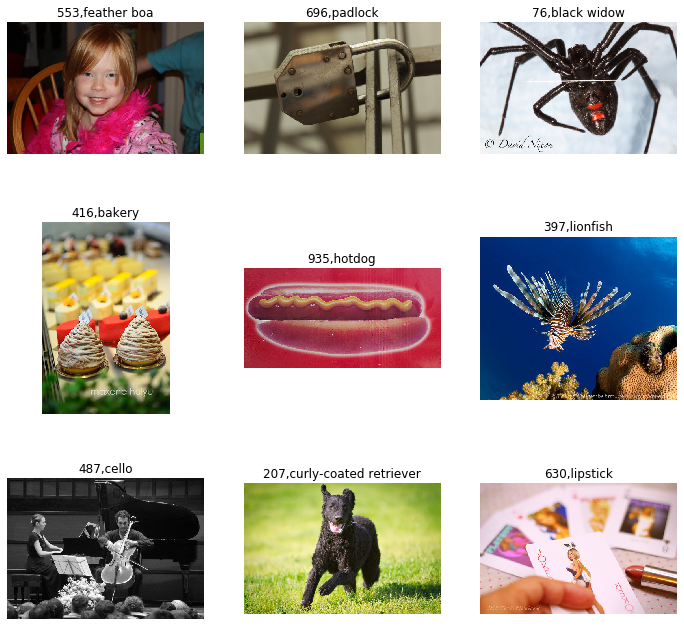

In [6]:
# 이미지 확인
import PIL.Image as Image
import matplotlib.pyplot as plt
import random
all_image_paths = list(data_root.glob('*/*'))
all_image_paths  = [str(path) for path in all_image_paths]

# 이미지를 랜덤하게 섞자
random.shuffle(all_image_paths)

image_count = len(all_image_paths)
print('image_count :', image_count)

plt.figure(figsize=(12,12))
for c in range(9):
  image_path = random.choice(all_image_paths)
  plt.subplot(3,3,c+1)
  plt.imshow(plt.imread(image_path))
  idx = int(image_path.split('/')[-2]) + 1
  plt.title(str(idx) + ',' + label_text[idx])
  plt.axis('off')
plt.show()

출력에서는 10,000장의 이미지 중 랜덤하게 뽑은 9장의 이미지를 확인할 수 있다.

한가지 유의해야 할 점은 라벨 텍스트는 background가 포함돼 있어서 총 1,001개의 텍스트가 있지만 실제 데이터의 라벨은 0에서 999까지의 1000라는 점이다.

이 차이를 무마하기 위해 idx = int(image_path.split('/')[-2] + 1에서는 파일 경로의 라벨 디렉터리에 해당하는 부분을 정수로 변환한 다음 1을 더해서 첫번째로부터 1,000번째까지의 라벨 텍스트가 동일한 값을 가리키게 한다.

In [7]:
# MobileNet의 분류 성능 확인
import  cv2
import numpy as np

top_1 = 0
top_5 = 0
for image_path in all_image_paths:
  img = cv2.imread(image_path)
  img = cv2.resize(img, dsize=(224,224))
  img = img/225.0
  img = np.expand_dims(img, axis=0)
  top_5_predict = model.predict(img)[0].argsort()[::-1][:5] # argsort()는 값을 정렬하는 대신 인덱스를 정렬한다.
  idx = int(image_path.split('/')[-2])+1
  if idx in top_5_predict:
    top_5 += 1
    if top_5_predict[0] == idx:
      top_1 += 1

print('Top-5 correctness:', top_5 / len(all_image_paths) * 100, '%')
print('Top-1 correctness:', top_1 / len(all_image_paths) * 100, '%')

Top-5 correctness: 83.39999999999999 %
Top-1 correctness: 59.06 %


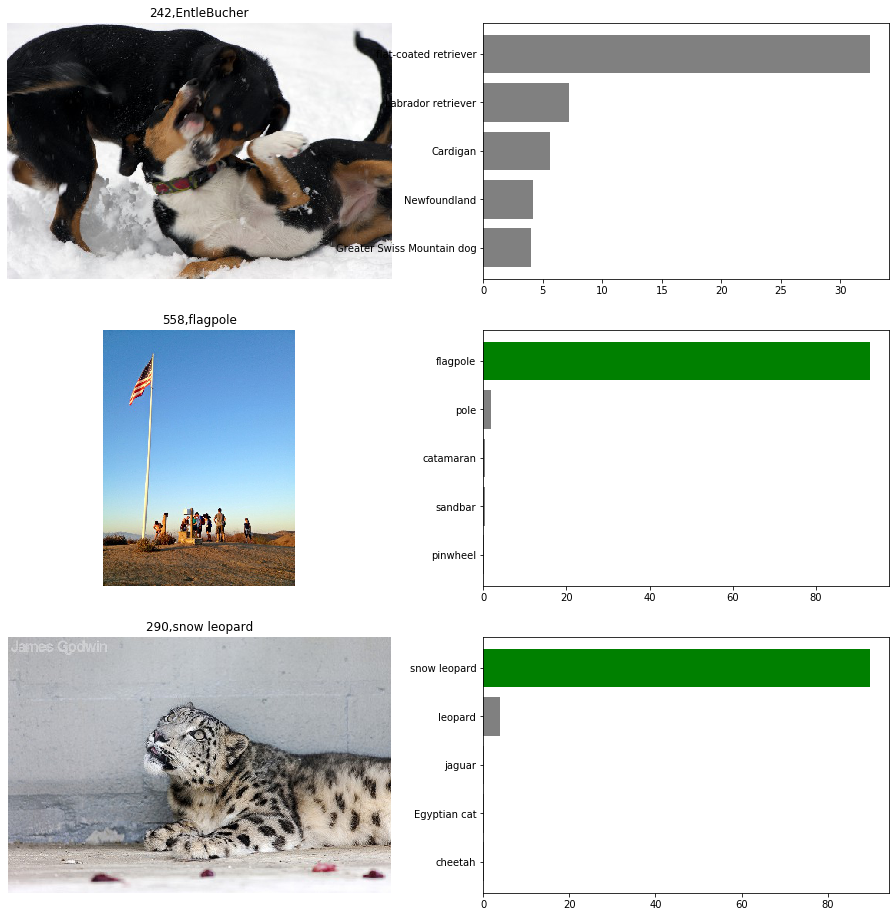

In [8]:
# MobileNet의 분류 라벨 확인
plt.figure(figsize=(16,16))

def softmax(x):
  e_x = np.exp(x - np.max(x))
  return e_x / e_x.sum(axis=0)
  
for c in range(3):
  image_path = random.choice(all_image_paths)

  # 이미지 표시
  plt.subplot(3,2,c*2+1)
  plt.imshow(plt.imread(image_path))
  idx = int(image_path.split('/')[-2]) + 1
  plt.title(str(idx) + ',' + label_text[idx])
  plt.axis('off')

  # 예측값 표시
  plt.subplot(3,2,c*2+2)
  img = cv2.imread(image_path)
  img = cv2.resize(img, dsize=(224,224))
  img = img / 255.0
  img = np.expand_dims(img, axis=0)

  # MobileNet을 이용한 예측
  logits = model.predict(img)[0]
  prediction = softmax(logits)

  # 가장 높은 확률의 예측값 5개를 뽑음
  top_5_predict = prediction.argsort()[::-1][:5]
  labels = [label_text[index] for index in top_5_predict]
  color = ['gray'] * 5
  if idx in top_5_predict:
    color[top_5_predict.tolist().index(idx)] = 'green'
  color = color[::-1]
  plt.barh(range(5), prediction[top_5_predict][::-1] * 100, color=color)
  plt.yticks(range(5), labels[::-1])              